#Présentation

On se propose de prédire dans ce notebook les chutes de pluie au moyen d'un réseau de neurones récurrents de type LSTM.

In [46]:
import numpy as np
import pandas as pd
import math
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
import tensorflow as tf
import keras.backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, mean_absolute_error, mean_squared_error, make_scorer, ConfusionMatrixDisplay, classification_report
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, Flatten
from keras.metrics import Metric, Precision, Recall
from keras.utils import metrics_utils, data_utils, plot_model
from keras.utils.generic_utils import to_list
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay


In [3]:
tf.keras.__version__

'2.12.0'

In [4]:
df_full = pd.read_csv("https://raw.githubusercontent.com/ArnoMac/weatherAUS/main/weatherAUS_Kapy_v2.csv", parse_dates=['Date'], index_col=0)
# On enlève les features constantes et inutiles
df = df_full.iloc[:, :24]
# On enlève les features non pertinentes.
df = df.drop(columns=['RainTomorrow', 'DayOfYear', 'Month', 'Latitude', 'Longitude'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145460 entries, 0 to 145459
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Date                    145460 non-null  datetime64[ns]
 1   Location                145460 non-null  object        
 2   Rainfall                142199 non-null  float64       
 3   WindGustSpeed           135197 non-null  float64       
 4   Temp9am                 144286 non-null  float64       
 5   diffTempMinMax          144035 non-null  float64       
 6   diffWind3pm9am          141844 non-null  float64       
 7   diffPressure9am3pm      130171 non-null  float64       
 8   Pressure                130656 non-null  float64       
 9   DeltaP_1d               130542 non-null  float64       
 10  DeltaP_2d               130494 non-null  float64       
 11  DeltaP_3d               130464 non-null  float64       
 12  diffHimidity9am3pm      140186

In [5]:
def plot_confusion_matrix(y_true, y_pred, display_labels):
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize=None, display_labels=display_labels)
    #disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='all', display_labels=display_labels, values_format='.3g')
    disp.figure_.set(figwidth=3, figheight=3)
    plt.show()

In [6]:
class TimeseriesScaler:
    """
    Cette classe normalise les données, ajoute des features de Fourier puis sépare les données
    en un jeu d'entraînement et un jeu de test.

    Méthodes
    --------
    train_test_split(self, df, location, n_harmonics=3, output_rainfall=0, n_lead=1, start_train_date='2011-07-01', start_test_date='2016-07-01')
        Normalise les données, ajoute des features de Fourier et sépare les données.
    """

    def __init__(self):
        return
    
    def __fourier_features(self, index, dates, start_date, period, order):
        """
        Paramètres
        ----------
        index : Index
            L'index à utiliser pour le DataFrame résultat
        dates : Series
            Les dates pour lesquelles il faut calculer les features de Fourier
        start_date : str
            La date correspondant au zéro du calcul des features de Fourier
        period : float
            La période de la série de Fourier
        order : int
            Le nombre d'harmoniques à générer

        Retour
        ------
        Un DataFrame avec 2 features par harmonique
        """

        time = (dates - start_date).days
        k = 2 * np.pi * (1 / period) * time
        features = {}
        for i in range(1, order + 1):
            features.update({
                f"sin_{period}_{i}": np.sin(i * k),
                f"cos_{period}_{i}": np.cos(i * k),
            })
        return pd.DataFrame(features, index=index)

    def train_test_split(self, df, location, n_harmonics=3, output_rainfall=0, n_lead=1, start_train_date='2011-07-01', start_test_date='2016-07-01'):
        """
        Paramètres
        ----------
        df : DataFrame
            Données de la série temporelle indexées selon le temps
        location : str
            Ville où effectuer l'entraînement
        n_harmonics : int
            Nombre d'harmoniques de Fourier à ajouter comme features
        output_rainfall : int
            Le type de données à retourner :
                0 : retourne RainTomorrow
                1 : retourne Rainfall
                2 : retourne RainTomorrow et Rainfall
        n_lead : int
            Indice du jour à prédire après le dernier jour
        start_train_date : str
            Date où commence l'ensemble d'entraînement
        start_test_date : str
            Date où se termine l'ensemble d'entraînement et où commence l'ensemble de test

        Retour
        ------
        Les données X_train, y_train, X_test, y_test
        """
        
        self.location = location
        self.n_harmonics = n_harmonics
        
        # Création de la série temporelle
        df_1 = df[df['Location']==location]
        df_1 = df_1.set_index('Date')
        df_1 = df_1.drop(columns='Location')
        
        # On enlève les lignes entèrement vides.
        df_1 = df_1[~df_1.isna().all(axis=1)]
        
        # On réindexe avec un index temporel complet.
        org_index = df_1.index.copy()
        new_index = pd.date_range(start=df_1.index.min(), end=df_1.index.max(), freq='D')
        df_1 = df_1.reindex(index=new_index)
        
        # On bouche les NaN par interpolation linéaire.
        df_1 = df_1.interpolate(method='linear', axis=0, limit_direction='both')
        
        # On enlève les colonnes vides
        self.cols_to_drop = list(df_1.columns[df_1.isna().any(axis=0)])
        if 'Rainfall' in self.cols_to_drop:
            self.cols_to_drop.remove('Rainfall') # on garde toujours Rainfall
        df_1 = df_1.drop(columns=self.cols_to_drop)
        
        # On décale Rainfall dans le temps
        df_1['Rainfall'] = df_1['Rainfall'].shift(-n_lead)
        df_1 = df_1.dropna()
        
        df_1 = df_1.astype('float32')        
        
        # Split train/test temporel.
        df_train = df_1[(df_1.index>=start_train_date)&(df_1.index<start_test_date)]
        df_test = df_1[df_1.index>=start_test_date]
        X_train = df_train.drop(columns='Rainfall')            
        X_test = df_test.drop(columns='Rainfall')
        if output_rainfall == 2:
            self.y_train = pd.concat([df_train['Rainfall'].to_frame(), df_train['Rainfall'].rename('RainTomorrow').gt(1.0).astype('float32').to_frame()], axis=1)
            self.y_test = pd.concat([df_test['Rainfall'].to_frame(), df_test['Rainfall'].rename('RainTomorrow').gt(1.0).astype('float32').to_frame()], axis=1)
        elif output_rainfall == 1:
            self.y_train = df_train['Rainfall']
            self.y_test = df_test['Rainfall']
        else:
            self.y_train = df_train['Rainfall'].gt(1.0).astype('float32')
            self.y_test = df_test['Rainfall'].gt(1.0).astype('float32')
        self.true_train_index = self.y_train.index.intersection(org_index)
        self.true_pred_index = self.y_test.index.intersection(org_index)
        
        has_test = (X_test.shape[0] != 0)
        
        # Scaling
        self.cols_to_scale = list(df_1.columns[2:].values)
        if ('WindDirInfluence' in self.cols_to_scale):
            self.cols_to_scale.remove('WindDirInfluence') # déjà normalisé
            
        self.scaler = StandardScaler()
        self.scaler.fit(X_train[self.cols_to_scale])
        X_train_scaled = X_train.copy()
        X_train_scaled[self.cols_to_scale] = self.scaler.transform(X_train[self.cols_to_scale])
        y_train_scaled = np.log1p(self.y_train)
        if has_test:
            X_test_scaled = X_test.copy()
            X_test_scaled[self.cols_to_scale] = self.scaler.transform(X_test[self.cols_to_scale])
        else:
            X_test_scaled = None
        
        # Ajout des features de Fourier
        self.start_date = new_index[0]
        self.X_train_fourier = X_train_scaled.join(self.__fourier_features(X_train_scaled.index, df_train.index, self.start_date, 365.25, n_harmonics), how='left')
        if (has_test):
            self.X_test_fourier = X_test_scaled.join(self.__fourier_features(X_test_scaled.index, df_test.index, self.start_date, 365.25, n_harmonics), how='left')
        else:
            self.X_test_fourier = None
        
        return self.X_train_fourier, self.y_train, self.X_test_fourier, self.y_test

In [7]:
# Cette classe est une adaptation de tf.keras.preprocessing.sequence.TimeseriesGenerator
# afin de gérer le multi-output.

class TimeseriesGeneratorMultiOutput(data_utils.Sequence):
    """Utility class for generating batches of temporal data.
    Deprecated: `tf.keras.preprocessing.sequence.TimeseriesGenerator` does not
    operate on tensors and is not recommended for new code. Prefer using a
    `tf.data.Dataset` which provides a more efficient and flexible mechanism for
    batching, shuffling, and windowing input. See the
    [tf.data guide](https://www.tensorflow.org/guide/data) for more details.
    This class takes in a sequence of data-points gathered at
    equal intervals, along with time series parameters such as
    stride, length of history, etc., to produce batches for
    training/validation.
    Arguments:
        data: Indexable generator (such as list or Numpy array)
            containing consecutive data points (timesteps).
            The data should be at 2D, and axis 0 is expected
            to be the time dimension.
        targets: Targets corresponding to timesteps in `data`.
            It should have same length as `data`.
        length: Length of the output sequences (in number of timesteps).
        sampling_rate: Period between successive individual timesteps
            within sequences. For rate `r`, timesteps
            `data[i]`, `data[i-r]`, ... `data[i - length]`
            are used for create a sample sequence.
        stride: Period between successive output sequences.
            For stride `s`, consecutive output samples would
            be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
        start_index: Data points earlier than `start_index` will not be used
            in the output sequences. This is useful to reserve part of the
            data for test or validation.
        end_index: Data points later than `end_index` will not be used
            in the output sequences. This is useful to reserve part of the
            data for test or validation.
        shuffle: Whether to shuffle output samples,
            or instead draw them in chronological order.
        reverse: Boolean: if `true`, timesteps in each output sample will be
            in reverse chronological order.
        batch_size: Number of timeseries samples in each batch
            (except maybe the last one).
    Returns:
        A [Sequence](
        https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence)
        instance.
    Examples:
        ```python
        from keras.preprocessing.sequence import TimeseriesGenerator
        import numpy as np
        data = np.array([[i] for i in range(50)])
        targets = np.array([[i] for i in range(50)])
        data_gen = TimeseriesGenerator(data, targets,
                                       length=10, sampling_rate=2,
                                       batch_size=2)
        assert len(data_gen) == 20
        batch_0 = data_gen[0]
        x, y = batch_0
        assert np.array_equal(x,
                              np.array([[[0], [2], [4], [6], [8]],
                                        [[1], [3], [5], [7], [9]]]))
        assert np.array_equal(y,
                              np.array([[10], [11]]))
        ```
    """

    def __init__(
        self,
        data,
        targets,
        length,
        sampling_rate=1,
        stride=1,
        start_index=0,
        end_index=None,
        shuffle=False,
        reverse=False,
        batch_size=128,
        output_names=None
    ):

        if len(data) != len(targets):
            raise ValueError(
                "Data and targets have to be"
                + f" of same length. Data length is {len(data)}"
                + f" while target length is {len(targets)}"
            )
            
        st = np.shape(targets)
        if output_names is not None and len(output_names) != st[1]:
            raise ValueError(
                "Multi-output targets require a valid output_names"
            )
                
        self.data = np.asarray(data)
        self.targets = np.asarray(targets)
        self.length = length
        self.sampling_rate = sampling_rate
        self.stride = stride
        self.start_index = start_index + length
        if end_index is None:
            end_index = len(data) - 1
        self.end_index = end_index
        self.shuffle = shuffle
        self.reverse = reverse
        self.batch_size = batch_size
        self.output_names = output_names

        if self.start_index > self.end_index:
            raise ValueError(
                "`start_index+length=%i > end_index=%i` "
                "is disallowed, as no part of the sequence "
                "would be left to be used as current step."
                % (self.start_index, self.end_index)
            )

    def __len__(self):
        return (
            self.end_index - self.start_index + self.batch_size * self.stride
        ) // (self.batch_size * self.stride)

    def __getitem__(self, index):
        if self.shuffle:
            rows = np.random.randint(
                self.start_index, self.end_index + 1, size=self.batch_size
            )
        else:
            i = self.start_index + self.batch_size * self.stride * index
            rows = np.arange(
                i,
                min(i + self.batch_size * self.stride, self.end_index + 1),
                self.stride,
            )

        samples = np.array(
            [
                self.data[row - self.length : row : self.sampling_rate]
                for row in rows
            ]
        )
        
        if self.output_names is not None:
            atargets = np.array([self.targets[row] for row in rows])
            axes = list(np.arange(len(np.shape(self.targets))))
            axes[0] = 1
            axes[1] = 0            
            atargets = np.transpose(atargets, axes=axes)
            
            targets = {}
            for i, n in enumerate(self.output_names):
                targets[n] = atargets[i]
        else:
            targets = np.array([self.targets[row] for row in rows])

        if self.reverse:
            return samples[:, ::-1, ...], targets
        return samples, targets

    def get_config(self):
        """Returns the TimeseriesGenerator configuration as Python dictionary.
        Returns:
            A Python dictionary with the TimeseriesGenerator configuration.
        """
        data = self.data
        if type(self.data).__module__ == np.__name__:
            data = self.data.tolist()
        try:
            json_data = json.dumps(data)
        except TypeError as e:
            raise TypeError("Data not JSON Serializable:", data) from e

        targets = self.targets
        if type(self.targets).__module__ == np.__name__:
            targets = self.targets.tolist()
        try:
            json_targets = json.dumps(targets)
        except TypeError as e:
            raise TypeError("Targets not JSON Serializable:", targets) from e

        return {
            "data": json_data,
            "targets": json_targets,
            "length": self.length,
            "sampling_rate": self.sampling_rate,
            "stride": self.stride,
            "start_index": self.start_index,
            "end_index": self.end_index,
            "shuffle": self.shuffle,
            "reverse": self.reverse,
            "batch_size": self.batch_size,
            "output_names": self.output_names,
        }

    def to_json(self, **kwargs):
        """Returns a JSON string containing the generator's configuration.
        Args:
            **kwargs: Additional keyword arguments to be passed
                to `json.dumps()`.
        Returns:
            A JSON string containing the tokenizer configuration.
        """
        config = self.get_config()
        timeseries_generator_config = {
            "class_name": self.__class__.__name__,
            "config": config,
        }
        return json.dumps(timeseries_generator_config, **kwargs)


In [15]:
# Cette classe est une recopie de tf.keras.metrics.F1Score qui n'est pas disponible sur les versions
# un peu anciennes de Keras.

class F1Score(Metric):
    r"""Computes F-1 Score.
    This is the harmonic mean of precision and recall.
    Its output range is `[0, 1]`. It works for both multi-class
    and multi-label classification.
    It is defined as:
    ```python
    f1_score = 2 * (precision * recall) / (precision + recall)
    ```
    Args:
        average: Type of averaging to be performed on data.
            Acceptable values are `None`, `"micro"`, `"macro"`
            and `"weighted"`. Default value is `None`.
            If `None`, no averaging is performed and `result()` will return
            the score for each class.
            If `"micro"`, compute metrics globally by counting the total
            true positives, false negatives and false positives.
            If `"macro"`, compute metrics for each label,
            and return their unweighted mean.
            This does not take label imbalance into account.
            If `"weighted"`, compute metrics for each label,
            and return their average weighted by support
            (the number of true instances for each label).
            This alters `"macro"` to account for label imbalance.
            It can result in an score that is not between precision and recall.
        threshold: Elements of `y_pred` greater than `threshold` are
            converted to be 1, and the rest 0. If `threshold` is
            `None`, the argmax of `y_pred` is converted to 1, and the rest to 0.
        name: Optional. String name of the metric instance.
        dtype: Optional. Data type of the metric result.
    Returns:
        F-1 Score: float.
    Example:
    >>> metric = tf.keras.metrics.F1Score(threshold=0.5)
    >>> y_true = np.array([[1, 1, 1],
    ...                    [1, 0, 0],
    ...                    [1, 1, 0]], np.int32)
    >>> y_pred = np.array([[0.2, 0.6, 0.7],
    ...                    [0.2, 0.6, 0.6],
    ...                    [0.6, 0.8, 0.0]], np.float32)
    >>> metric.update_state(y_true, y_pred)
    >>> result = metric.result()
    >>> result.numpy()
    array([0.5      , 0.8      , 0.6666667], dtype=float32)
    """
    
    def __init__(self,
               thresholds=None,
               top_k=None,
               class_id=None,
               name=None,
               dtype=None):
        super(F1Score, self).__init__(name=name, dtype=dtype)
        self.init_thresholds = thresholds
        self.top_k = top_k
        self.class_id = class_id

        default_threshold = 0.5 if top_k is None else metrics_utils.NEG_INF
        self.thresholds = metrics_utils.parse_init_thresholds(
            thresholds, default_threshold=default_threshold)
        self._thresholds_distributed_evenly = (
            metrics_utils.is_evenly_distributed_thresholds(self.thresholds))
        self.true_positives = self.add_weight(
            'true_positives',
            shape=(len(self.thresholds),),
            initializer=tf.compat.v1.zeros_initializer)
        self.false_positives = self.add_weight(
            'false_positives',
            shape=(len(self.thresholds),),
            initializer=tf.compat.v1.zeros_initializer)
        self.false_negatives = self.add_weight(
            'false_negatives',
            shape=(len(self.thresholds),),
            initializer=tf.compat.v1.zeros_initializer)

    def update_state(self, y_true, y_pred, sample_weight=None):
        """Accumulates true positive and false positive statistics.
        Args:
          y_true: The ground truth values, with the same dimensions as `y_pred`.
            Will be cast to `bool`.
          y_pred: The predicted values. Each element must be in the range `[0, 1]`.
          sample_weight: Optional weighting of each example. Defaults to 1. Can be a
            `Tensor` whose rank is either 0, or the same rank as `y_true`, and must
            be broadcastable to `y_true`.
        Returns:
          Update op.
        """
        return metrics_utils.update_confusion_matrix_variables(
            {
                metrics_utils.ConfusionMatrix.TRUE_POSITIVES: self.true_positives,
                metrics_utils.ConfusionMatrix.FALSE_POSITIVES: self.false_positives,
                metrics_utils.ConfusionMatrix.FALSE_NEGATIVES: self.false_negatives
            },
            y_true,
            y_pred,
            thresholds=self.thresholds,
            thresholds_distributed_evenly=self._thresholds_distributed_evenly,
            top_k=self.top_k,
            class_id=self.class_id,
            sample_weight=sample_weight)

    def result(self):
        result = tf.math.divide_no_nan(2 * self.true_positives,
                                     2 * self.true_positives + self.false_positives + self.false_negatives)
        return result[0] if len(self.thresholds) == 1 else result

    def reset_state(self):
        num_thresholds = len(to_list(self.thresholds))
        K.batch_set_value([(v, np.zeros((num_thresholds,)))
                                 for v in (self.true_positives,
                                           self.false_positives, self.false_negatives)])

    def get_config(self):
        config = {
            'thresholds': self.init_thresholds,
            'top_k': self.top_k,
            'class_id': self.class_id
        }
        base_config = super(Metric, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Analyse de la pluviosité à Melbourne
On utilise un réseau de neurones récurrents avec une sortie logistique indiquant s'il pleuvra ou non.

On va chercher à optimiser le score F1 sur l'ensemble de test.

In [109]:
location = 'Melbourne'
X_train1, y_train1, X_test1, y_test1 = TimeseriesScaler().train_test_split(df, location, n_harmonics=2)

In [110]:
window_size=7
batch_size=32
num_features = X_train1.shape[1]
train_size = X_train1.shape[0]

train_generator1 = TimeseriesGeneratorMultiOutput(X_train1, y_train1, length=window_size, stride=1, batch_size=batch_size)
test_generator1 = TimeseriesGeneratorMultiOutput(X_test1, y_test1, length=window_size, stride=1, batch_size=batch_size)

Model: "weather"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm1 (LSTM)                (None, 7, 64)             21760     
                                                                 
 lstm2 (LSTM)                (None, 64)                33024     
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 54,849
Trainable params: 54,849
Non-trainable params: 0
_________________________________________________________________


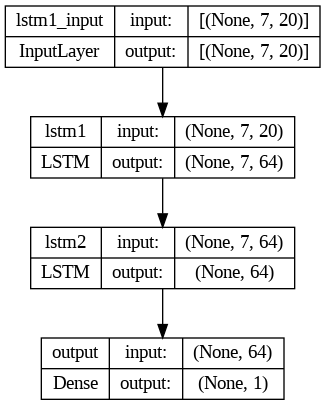

In [113]:
lstm_units = 64
epochs=50

model1 = Sequential(name='weather')
model1.add(LSTM(lstm_units, activation='tanh', dropout=0.2, return_sequences=True, input_shape=(window_size, num_features), name='lstm1'))
model1.add(LSTM(lstm_units, activation='tanh', dropout=0.4, name='lstm2'))
model1.add(Dense(1, activation='sigmoid', name='output'))

initial_learning_rate = 1e-3
final_learning_rate = 1e-5
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(train_size/batch_size)

lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=steps_per_epoch,
    decay_rate=learning_rate_decay_factor,
    staircase=True)

model1.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr_schedule),
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), F1Score(name='f1_score')])
model1.summary()
plot_model(model1, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=False, filename='model.png')

In [114]:
early_stop = EarlyStopping(monitor="val_f1_score", min_delta=0.001, patience=10, mode='max', restore_best_weights=True, start_from_epoch=15)

hist1 = model1.fit(train_generator1, verbose=2, epochs=epochs, validation_data=test_generator1,
                          callbacks=[early_stop]
                          )

Epoch 1/50
57/57 - 6s - loss: 0.6996 - accuracy: 0.5143 - precision: 0.5300 - recall: 0.4192 - f1_score: 0.4681 - val_loss: 0.6885 - val_accuracy: 0.5710 - val_precision: 0.3368 - val_recall: 0.7386 - val_f1_score: 0.4626 - 6s/epoch - 105ms/step
Epoch 2/50
57/57 - 1s - loss: 0.6184 - accuracy: 0.6511 - precision: 0.6314 - recall: 0.7586 - f1_score: 0.6892 - val_loss: 0.6476 - val_accuracy: 0.6165 - val_precision: 0.3423 - val_recall: 0.5795 - val_f1_score: 0.4304 - 1s/epoch - 19ms/step
Epoch 3/50
57/57 - 1s - loss: 0.5617 - accuracy: 0.7049 - precision: 0.7523 - recall: 0.6282 - f1_score: 0.6847 - val_loss: 0.6160 - val_accuracy: 0.6477 - val_precision: 0.3714 - val_recall: 0.5909 - val_f1_score: 0.4561 - 681ms/epoch - 12ms/step
Epoch 4/50
57/57 - 1s - loss: 0.5287 - accuracy: 0.7159 - precision: 0.7449 - recall: 0.6735 - f1_score: 0.7074 - val_loss: 0.6147 - val_accuracy: 0.6875 - val_precision: 0.4257 - val_recall: 0.7159 - val_f1_score: 0.5339 - 660ms/epoch - 12ms/step
Epoch 5/50
57

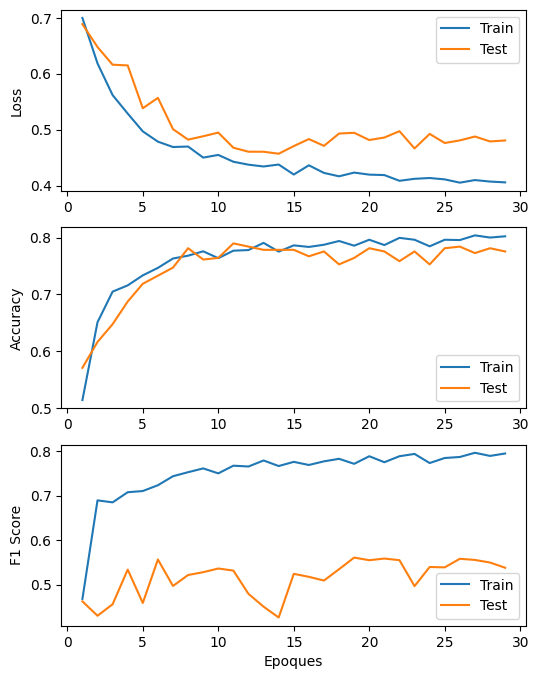

In [115]:
epoch_count = len(hist1.history['loss'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
plt.plot(np.arange(1, epoch_count+1), hist1.history['loss'], label='Train')
plt.plot(np.arange(1, epoch_count+1), hist1.history['val_loss'], label='Test')
plt.legend()
plt.xlabel(None)
plt.ylabel('Loss')
plt.subplot(312)
plt.plot(np.arange(1, epoch_count+1), hist1.history['accuracy'], label='Train')
plt.plot(np.arange(1, epoch_count+1), hist1.history['val_accuracy'], label='Test')
plt.legend()
plt.xlabel(None)
plt.ylabel('Accuracy')
plt.subplot(313)
plt.plot(np.arange(1, epoch_count+1), hist1.history['f1_score'], label='Train')
plt.plot(np.arange(1, epoch_count+1), hist1.history['val_f1_score'], label='Test')
plt.legend()
plt.xlabel('Epoques')
plt.ylabel('F1 Score')
plt.show()

In [116]:
_ = model1.evaluate(test_generator1, verbose=2)

11/11 - 0s - loss: 0.4943 - accuracy: 0.7642 - precision: 0.5248 - recall: 0.6023 - f1_score: 0.5608 - 76ms/epoch - 7ms/step


## Analyse de la pluviosité à Melbourne (suite)
Afin d'améliorer le score, il semble intéressant de "guider" le réseau en lui apportant en plus de l'information binaire *pluie/pas pluie* l'information de pluviométrie.

On ajoute donc une deuxième sortie au réseau en espérant que l'optimisation sur la pluviométrie améliorera aussi la prédiction binaire de chute de pluie.

In [117]:
location = 'Melbourne'
X_train2, y_train2, X_test2, y_test2 = TimeseriesScaler().train_test_split(df, location, n_harmonics=2,output_rainfall=2)

In [118]:
# On transforme la pluviométrie au moyen de la fonction log1p pour réduire la dispersion de sa distribution.

y_train2['Rainfall'] = np.log1p(y_train2['Rainfall'])
y_test2['Rainfall'] = np.log1p(y_test2['Rainfall'])
y_train2.head()

,Rainfall,RainTomorrow
2011-07-01,0.000000,0.0
2011-07-02,0.000000,0.0
2011-07-03,0.182322,0.0
2011-07-04,0.000000,0.0
2011-07-05,1.029619,1.0


In [119]:
window_size=7
batch_size=32
num_features = X_train2.shape[1]
train_size = X_train2.shape[0]
output_names=['rainfall', 'raintomorrow']

train_generator2 = TimeseriesGeneratorMultiOutput(X_train2, y_train2, length=window_size, stride=1, batch_size=batch_size, output_names=output_names)
test_generator2 = TimeseriesGeneratorMultiOutput(X_test2, y_test2, length=window_size, stride=1, batch_size=batch_size, output_names=output_names)

Model: "weather"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 7, 20)]      0           []                               
                                                                                                  
 lstm1 (LSTM)                   (None, 7, 64)        21760       ['input[0][0]']                  
                                                                                                  
 lstm2 (LSTM)                   (None, 64)           33024       ['lstm1[0][0]']                  
                                                                                                  
 rainfall (Dense)               (None, 1)            65          ['lstm2[0][0]']                  
                                                                                            

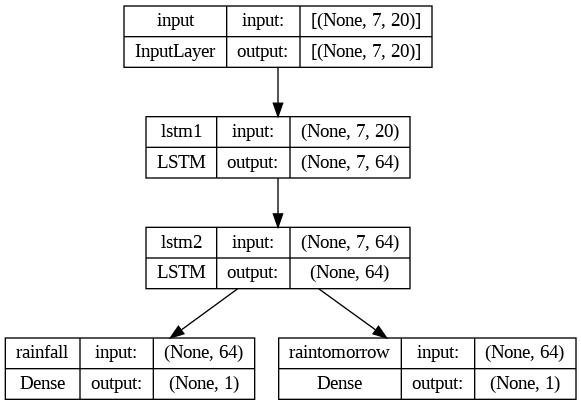

In [120]:
lstm_units = 64
epochs=50
rainfall_loss_weight = 0.5 # Poids relatif de rainfall par rapport à raintomorrow dans la loss.

inputs = Input(shape=(window_size, num_features), name='input')
lstm1 = LSTM(lstm_units, activation='tanh', dropout=0.2, return_sequences=True, name='lstm1')
lstm2 = LSTM(lstm_units, activation='tanh', dropout=0.4, name='lstm2')
dense_rainfall = Dense(1, activation='linear', name='rainfall')
dense_raintomorrow = Dense(1, activation='sigmoid', name='raintomorrow')

x = lstm1(inputs)
x = lstm2(x)
output_rainfall = dense_rainfall(x)
output_raintomorrow = dense_raintomorrow(x)

model2 = Model(inputs=inputs, outputs=[output_rainfall, output_raintomorrow], name='weather')

initial_learning_rate = 1e-3
final_learning_rate = 1e-5
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(train_size/batch_size)

lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=steps_per_epoch,
    decay_rate=learning_rate_decay_factor,
    staircase=True)

model2.compile(loss={'rainfall':'mse', 'raintomorrow':'binary_crossentropy'},
              loss_weights={'rainfall':rainfall_loss_weight, 'raintomorrow':1.0},
              optimizer=Adam(learning_rate=lr_schedule),
              metrics={
                  'rainfall':['mean_squared_error'],
                  'raintomorrow':['accuracy', Precision(name='precision'), Recall(name='recall'), F1Score(name='f1_score')]
              })
model2.summary()
plot_model(model2, show_shapes=True, show_layer_names=True, to_file='model.png')
display(Image(retina=False, filename='model.png'))

In [121]:
early_stop = EarlyStopping(monitor="val_raintomorrow_f1_score", min_delta=0.001, patience=10, mode='max', restore_best_weights=True, start_from_epoch=15)

hist2 = model2.fit(train_generator2, verbose=2, epochs=epochs, validation_data=test_generator2,
                          callbacks=[early_stop]
                          )

Epoch 1/50
57/57 - 8s - loss: 1.1886 - rainfall_loss: 0.9762 - raintomorrow_loss: 0.7005 - rainfall_mean_squared_error: 0.9762 - raintomorrow_accuracy: 0.5088 - raintomorrow_precision: 0.5149 - raintomorrow_recall: 0.6315 - raintomorrow_f1_score: 0.5673 - val_loss: 1.2726 - val_rainfall_loss: 1.1856 - val_raintomorrow_loss: 0.6798 - val_rainfall_mean_squared_error: 1.1856 - val_raintomorrow_accuracy: 0.6420 - val_raintomorrow_precision: 0.3538 - val_raintomorrow_recall: 0.5227 - val_raintomorrow_f1_score: 0.4220 - 8s/epoch - 140ms/step
Epoch 2/50
57/57 - 1s - loss: 1.0357 - rainfall_loss: 0.7792 - raintomorrow_loss: 0.6461 - rainfall_mean_squared_error: 0.7792 - raintomorrow_accuracy: 0.6907 - raintomorrow_precision: 0.7140 - raintomorrow_recall: 0.6562 - raintomorrow_f1_score: 0.6839 - val_loss: 1.0692 - val_rainfall_loss: 0.8644 - val_raintomorrow_loss: 0.6370 - val_rainfall_mean_squared_error: 0.8644 - val_raintomorrow_accuracy: 0.6733 - val_raintomorrow_precision: 0.3826 - val_rain

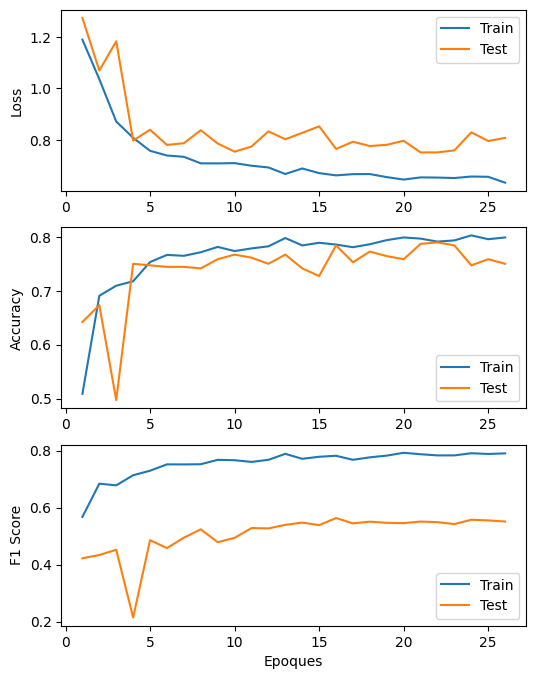

In [122]:
epoch_count = len(hist2.history['loss'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
plt.plot(np.arange(1, epoch_count+1), hist2.history['loss'], label='Train')
plt.plot(np.arange(1, epoch_count+1), hist2.history['val_loss'], label='Test')
plt.legend()
plt.xlabel(None)
plt.ylabel('Loss')
plt.subplot(312)
plt.plot(np.arange(1, epoch_count+1), hist2.history['raintomorrow_accuracy'], label='Train')
plt.plot(np.arange(1, epoch_count+1), hist2.history['val_raintomorrow_accuracy'], label='Test')
plt.legend()
plt.xlabel(None)
plt.ylabel('Accuracy')
plt.subplot(313)
plt.plot(np.arange(1, epoch_count+1), hist2.history['raintomorrow_f1_score'], label='Train')
plt.plot(np.arange(1, epoch_count+1), hist2.history['val_raintomorrow_f1_score'], label='Test')
plt.legend()
plt.xlabel('Epoques')
plt.ylabel('F1 Score')
plt.show()

In [123]:
_ = model2.evaluate(test_generator2, verbose=2)

11/11 - 0s - loss: 0.7659 - rainfall_loss: 0.5489 - raintomorrow_loss: 0.4914 - rainfall_mean_squared_error: 0.5489 - raintomorrow_accuracy: 0.7841 - raintomorrow_precision: 0.5698 - raintomorrow_recall: 0.5568 - raintomorrow_f1_score: 0.5632 - 126ms/epoch - 11ms/step


In [124]:
test_pred = model2.predict(test_generator2)
y_pred_rainfall = test_pred[0]
y_pred_rainfall = np.expm1(y_pred_rainfall)
y_test_rainfall = np.expm1(y_test2['Rainfall'])[window_size:]

y_pred_raintomorrow = (test_pred[1] >= 0.5).astype('float32')
y_pred_raintomorrow_from_rainfall = (y_pred_rainfall > 1.0).astype('float32')
y_test_raintomorrow = y_test2['RainTomorrow'][window_size:]
x_date = y_test2.index[window_size:]

11/11 [==============================] - 3s 7ms/step


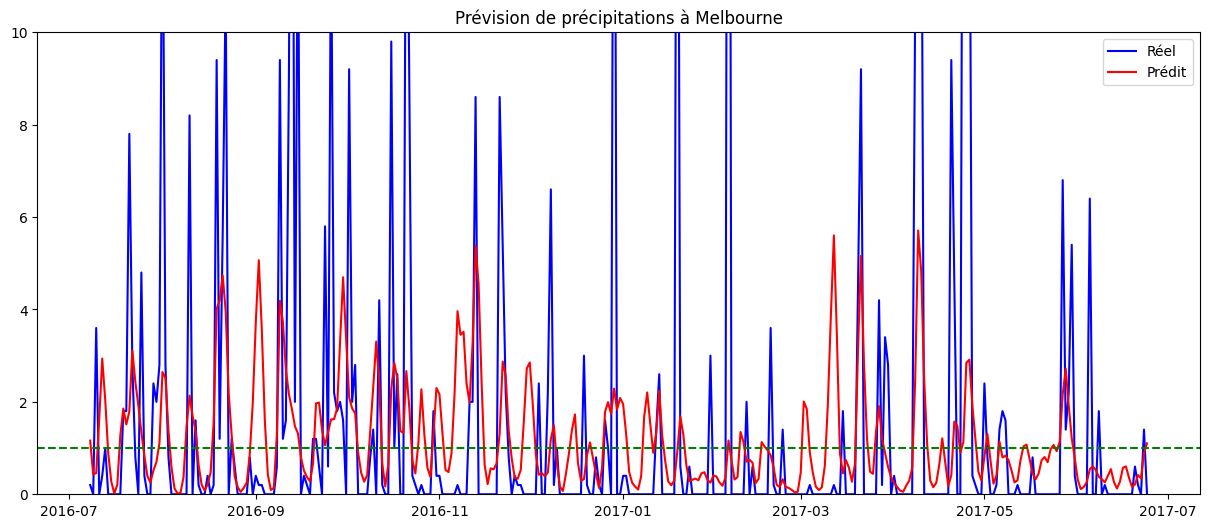

In [125]:
plt.figure(figsize=(15,6))
plt.plot(x_date, np.asarray(y_test_rainfall), color='blue', label='Réel')
plt.plot(x_date, np.asarray(y_pred_rainfall), color='red', label='Prédit')
plt.ylim(0,10)
plt.axhline(y=1, color='green', ls='--')
plt.title(f'Prévision de précipitations à {location}')
plt.legend()
plt.show()

              precision    recall  f1-score   support

         0.0       0.85      0.86      0.86       264
         1.0       0.57      0.56      0.56        88

    accuracy                           0.78       352
   macro avg       0.71      0.71      0.71       352
weighted avg       0.78      0.78      0.78       352



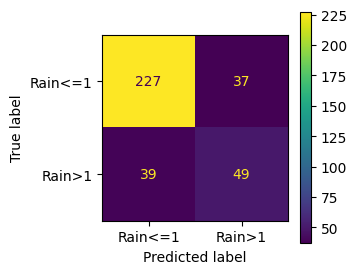

In [126]:
print(classification_report(y_test_raintomorrow, y_pred_raintomorrow))
plot_confusion_matrix(y_test_raintomorrow, y_pred_raintomorrow, display_labels=['Rain<=1', 'Rain>1'])

              precision    recall  f1-score   support

         0.0       0.89      0.67      0.76       264
         1.0       0.43      0.75      0.55        88

    accuracy                           0.69       352
   macro avg       0.66      0.71      0.66       352
weighted avg       0.77      0.69      0.71       352



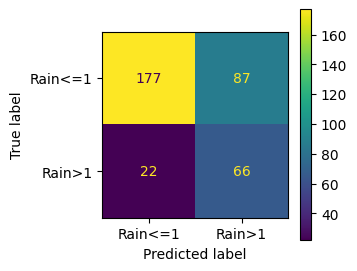

In [127]:
print(classification_report(y_test_raintomorrow, y_pred_raintomorrow_from_rainfall))
plot_confusion_matrix(y_test_raintomorrow, y_pred_raintomorrow_from_rainfall, display_labels=['Rain<=1', 'Rain>1'])